In [52]:
import networkx as nx

# Other packages for manupulating data
import numpy as np
import pandas as pd

# packages for plotting
import matplotlib.pyplot as plt

In [53]:
edgelist_df = pd.DataFrame({'node1':['s', 's', 'u', 'u', 'v'], 'node2':['u', 'v', 'v', 't', 't'], 
                            'weights':[3, 2, 0.7, 1, 7]
                           })
edgelist_df

,node1,node2,weights
0,s,u,3.0
1,s,v,2.0
2,u,v,0.7
3,u,t,1.0
4,v,t,7.0


In [54]:
g = nx.DiGraph()
for i, elrow in edgelist_df.iterrows():
    g.add_edge(elrow[0], elrow[1], weight=elrow[2])
g.edges(data=True)

OutEdgeDataView([('s', 'u', {'weight': 3.0}), ('s', 'v', {'weight': 2.0}), ('u', 'v', {'weight': 0.7}), ('u', 't', {'weight': 1.0}), ('v', 't', {'weight': 7.0})])

In [55]:
# for each node we are trying to fix the coordinates
g.add_node('s',pos=(0,1))
g.add_node('u',pos=(1,2))
g.add_node('v',pos=(1,0))
g.add_node('t',pos=(2,1))
g.nodes(data=True)

NodeDataView({'s': {'pos': (0, 1)}, 'u': {'pos': (1, 2)}, 'v': {'pos': (1, 0)}, 't': {'pos': (2, 1)}})

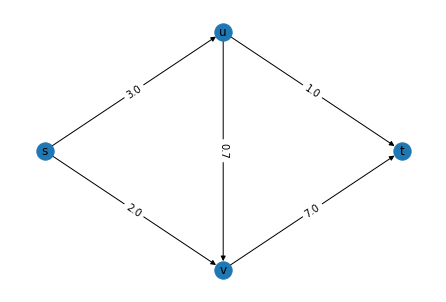

In [56]:
# This function gets the coordinates for nodes
pos = nx.get_node_attributes(g,'pos')

# This function gets the weights for the edges 
weight = nx.get_edge_attributes(g,'weight')

# The simplest way to draw a graph is by using nx.draw. 
nx.draw(g,pos, with_labels=True)

# This adds edge lables
nx.draw_networkx_edge_labels(g,pos,edge_labels = weight)
plt.show()

In [57]:
path_2_0 = nx.shortest_path(g, source ='s',target = 't')
path_2_0

['s', 'u', 't']

In [43]:
from ortools.sat.python import cp_model
shortest_path_model = cp_model.CpModel()

In [44]:
# Creating one integer decision variable for each edge
edge_bool_vars = {}
for edge in g.edges:
    edge_bool_vars[edge[0], edge[1]] = shortest_path_model.NewBoolVar('edge_%s_%s' % edge)
    print('Creating the boolean variable ', edge_bool_vars[edge[0], edge[1]], 
          'representing the if we should travel through ', (edge[0], edge[1]))

Creating the boolean variable  edge_s_u representing the if we should travel through  ('s', 'u')
Creating the boolean variable  edge_s_v representing the if we should travel through  ('s', 'v')
Creating the boolean variable  edge_u_v representing the if we should travel through  ('u', 'v')
Creating the boolean variable  edge_u_t representing the if we should travel through  ('u', 't')
Creating the boolean variable  edge_v_t representing the if we should travel through  ('v', 't')


In [45]:
input_node = 's'
output_node = 't'

In [46]:
# Adding constraints on the nodes
for node in g.nodes:
    in_edges = g.in_edges(node)
    out_edges = g.out_edges(node)
    print('Adding the constraint on node ', node)
    print('This node has %i in-edges and %i out-edges' % (len(in_edges), len(out_edges)))
    equation_at_this_edge = sum(edge_bool_vars[edge[0], edge[1]] for edge in in_edges) - \
                            sum(edge_bool_vars[edge[0], edge[1]] for edge in out_edges)
    if(node == input_node):              
        shortest_path_model.Add(equation_at_this_edge == -1)
        print(equation_at_this_edge == -1)
    elif(node == output_node):              
        shortest_path_model.Add(equation_at_this_edge == 1)
        print(equation_at_this_edge == 1)
    else:
        shortest_path_model.Add(equation_at_this_edge == 0)
        print(equation_at_this_edge, '== 0')
    print('')

Adding the constraint on node  s
This node has 0 in-edges and 2 out-edges
(-((edge_s_u) + edge_s_v)) == -1

Adding the constraint on node  u
This node has 1 in-edges and 2 out-edges
((edge_s_u) + -((edge_u_v) + edge_u_t)) == 0

Adding the constraint on node  v
This node has 2 in-edges and 1 out-edges
(((edge_s_v) + edge_u_v) + -(edge_v_t)) == 0

Adding the constraint on node  t
This node has 2 in-edges and 0 out-edges
(((edge_u_t) + edge_v_t)) == 1



In [47]:
# factor to make everything including costs integer
factor_to_int = 10

# The objective is to maximise flow 
total_cost = sum(int(g.get_edge_data(*edge)['weight']*factor_to_int)*edge_bool_vars[edge[0], edge[1]]
                for edge in g.edges)

print('Objective is to optimise cost')
print(total_cost)
shortest_path_model.Minimize(total_cost)

Objective is to optimise cost
((((((30 * edge_s_u)) + (20 * edge_s_v)) + (7 * edge_u_v)) + (10 * edge_u_t)) + (70 * edge_v_t))


In [48]:
# Solving the problem
solver = cp_model.CpSolver()
solution_printer = cp_model.ObjectiveSolutionPrinter()
status = solver.SolveWithSolutionCallback(shortest_path_model, solution_printer)

Solution 0, time = 0.00 s, objective = 40


In [49]:
cp_model.OPTIMAL == status

True

In [50]:
result_edges = {}
for edge in g.edges:
    result_edges[edge[0], edge[1]] = solver.Value(edge_bool_vars[edge[0], edge[1]])
result_edges

{('s', 'u'): 1, ('s', 'v'): 0, ('u', 'v'): 0, ('u', 't'): 1, ('v', 't'): 0}

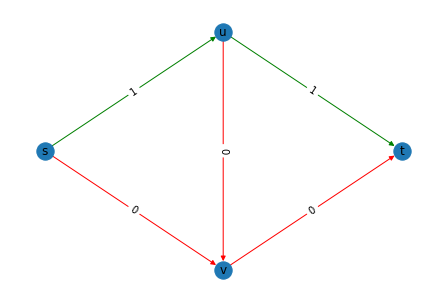

In [51]:
# This function gets the coordinates for nodes
pos = nx.get_node_attributes(g,'pos')
color = ['g' if val==1 else 'r' for val in result_edges.values()]

# The simplest way to draw a graph is by using nx.draw. 
nx.draw(g,pos, with_labels=True, edge_color= color)

# This adds edge lables
nx.draw_networkx_edge_labels(g,pos,edge_labels = result_edges)
plt.show()